In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/d2l.ai_implementation/chapter8'

/content/drive/MyDrive/d2l.ai_implementation/chapter8


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from matplotlib import pyplot as plt

In [4]:
from ResNet import ResNet

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
transform = T.Compose([
    T.Resize((96, 96)),
    T.ToTensor(),
    T.Normalize(0.2860, 0.3530)
])

In [7]:
root = '/content'
train_set = datasets.FashionMNIST(
    root,
    train=True,
    transform=transform,
    download=True
)
test_set = datasets.FashionMNIST(
    root,
    train=False,
    transform=transform,
    download=True
)

100%|██████████| 26421880/26421880 [00:00<00:00, 118968094.12it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5606398.38it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 63189087.53it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7747498.02it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [8]:
batch_size = 128

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [9]:
arch = [(2,64), (2,128), (2,256), (2, 512)]
model_for_summary = ResNet(arch).to(device)
summary(model_for_summary, (1, 96, 96))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,928
       BatchNorm2d-6           [-1, 64, 24, 24]             128
            Conv2d-7           [-1, 64, 24, 24]          36,928
       BatchNorm2d-8           [-1, 64, 24, 24]             128
      Residual_blk-9           [-1, 64, 24, 24]               0
           Conv2d-10           [-1, 64, 24, 24]          36,928
      BatchNorm2d-11           [-1, 64, 24, 24]             128
           Conv2d-12           [-1, 64, 24, 24]          36,928
      BatchNorm2d-13           [-1, 64, 24, 24]             128
     Residual_blk-14           [-1, 64,

In [10]:
input = torch.randn(1, 1, 96, 96).float().to(device)
out = model_for_summary(input)
print(out)

tensor([[-0.0663, -0.1068, -0.0464, -0.0447, -0.0501,  0.0853, -0.0163, -0.0099,
         -0.0705, -0.0167]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [11]:
def train_run_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [12]:
def test_run_epoch(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(1)
            correct += pred.eq(target).sum().item()

            total_loss += loss.item()

        accuracy = correct / len(test_set)
        avg_loss = total_loss / len(test_loader)

    return accuracy, avg_loss

In [13]:
def train(model, device, train_loder, test_loader, optimizer, criterion, num_epochs):
    train_avg_losses = []
    test_avg_losses = []
    accuracies = []

    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")

        train_avg_loss = train_run_epoch(model, device, train_loader, optimizer, criterion)
        train_avg_losses.append(train_avg_loss)
        print(f"Average Train Loss = {train_avg_loss:.20f}")

        accuracy, test_avg_loss = test_run_epoch(model, device, test_loader)
        test_avg_losses.append(test_avg_loss)
        accuracies.append(accuracy)
        print(f"Average Test Loss = {test_avg_loss:.20f}")
        print(f"Test Accuracy = {accuracy:.2f}")
        print()

    return train_avg_losses, test_avg_losses, accuracies

In [21]:
num_epochs = 10
learning_rate = 0.01

resnet = ResNet(arch).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

In [22]:
train_losses, test_losses, accuracies = train(resnet, device, train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/10]
Average Train Loss = 1.16685829348147307449
Average Test Loss = 0.96579441616806804838
Test Accuracy = 0.63

Epoch [2/10]
Average Train Loss = 0.89135458868449679581
Average Test Loss = 0.84561926428275768775
Test Accuracy = 0.69

Epoch [3/10]
Average Train Loss = 0.82225628340168044339
Average Test Loss = 0.83691339817228194153
Test Accuracy = 0.69

Epoch [4/10]
Average Train Loss = 0.78176468051572856055
Average Test Loss = 0.76506575942039489746
Test Accuracy = 0.71

Epoch [5/10]
Average Train Loss = 0.75357508926249261449
Average Test Loss = 0.76803853315643122457
Test Accuracy = 0.71

Epoch [6/10]
Average Train Loss = 0.74058772531399597039
Average Test Loss = 0.74921170367470268925
Test Accuracy = 0.71

Epoch [7/10]
Average Train Loss = 0.72195474654118385605
Average Test Loss = 0.74685493300232708158
Test Accuracy = 0.72

Epoch [8/10]
Average Train Loss = 0.71092315224696323028
Average Test Loss = 0.75742216049870358940
Test Accuracy = 0.72

Epoch [9/10]
Average Tra

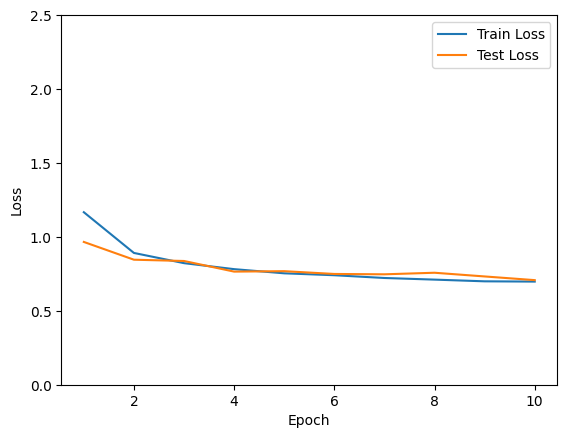

In [23]:
X = range(1, num_epochs+1)
plt.plot(X, train_losses, label="Train Loss")
plt.plot(X, test_losses, label="Test Loss")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

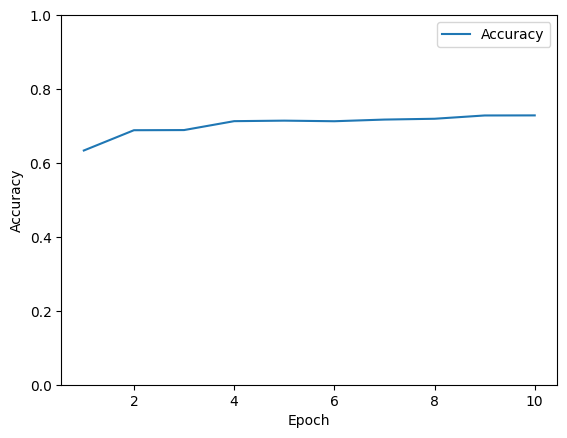

In [24]:
plt.plot(X, accuracies, label="Accuracy")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()